In [92]:
import numpy as np

from numpy.linalg import norm, inv, pinv
from utils import *
from visualize_utils import *
from tqdm import tqdm

# Read Data

In [104]:
# filename = "../data/03.npz"  # 03, 10
filename = "../data/10.npz"  # 03, 10
t,features,linear_velocity,angular_velocity,K,b,imu_T_cam = load_data(filename)

In [105]:
print(t.shape)
print(features.shape)
print(linear_velocity.shape)
print(angular_velocity.shape)

(1, 3026)
(4, 13289, 3026)
(3, 3026)
(3, 3026)


## feature preprocess

In [107]:
step = 20
sampled_features = np.zeros((4, int(features.shape[1]/step)+1, features.shape[2]))
for i, idx in enumerate(range(0, int(features.shape[1]), step)):
    sampled_features[:,i,:] = features[:,idx,:]

print(sampled_features.shape)

(4, 665, 3026)


# IMU Localization via EKF Prediction

In [109]:
def hat_map(vec):
    '''
        Transform vec in R^3 to a skew-symmetric vec_hat in R^3x3
        
        Input:
            vec - a 3x1 vector
        Output:
            vec_hat - a 3x3 matrix
    '''
    vec_hat = np.zeros((3,3))
    vec_hat[2,1] = vec[0]
    vec_hat[1,2] = -vec[0]
    vec_hat[2,0] = -vec[1]
    vec_hat[0,2] = vec[1]
    vec_hat[0,1] = -vec[2]
    vec_hat[1,0] = vec[2]
    return vec_hat

def adjoint(p, theta):
    '''
        Map u=[p,theta]^T in R^6 to se(3) in 4x4
        
        Input:
            p     - a 3x1 vector
            theta - a 3x1 vector
        Output:
            u_adjoint - a 6x6 matrix in SE(3)
    ''' 
    p_hat     = hat_map(p)
    theta_hat = hat_map(theta)
    u_adjoint = np.zeros((6,6))
    u_adjoint[:3,:3] = theta_hat
    u_adjoint[3:,3:] = theta_hat
    u_adjoint[:3,3:] = p_hat
    return u_adjoint

def twist(p, theta):
    '''
        Map u=[p,theta]^T in R^6 to the adjoint of SE(3) in 6x6
        
        Input:
            p     - a 3x1 vector
            theta - a 3x1 vector
        Output:
            twist - a 4x4 matrix in se(3)
    '''
    twist        = np.zeros((4,4))
    theta_hat    = hat_map(theta)
    twist[:3,:3] = theta_hat
    twist[:3,3]  = p
    return twist

def rodrigues_3(p, theta):
    '''
        u = [p,theta]^T
        Rodrigues formula for u where u is 6x1
    '''
    u  = twist(p,theta) # get u in SE(3)
    u2 = np.dot(u, u)   # u^2
    u3 = np.dot(u, u2)  # u^3
    u2_coeff = (1-np.cos(norm(theta)))/(norm(theta)**2)
    u3_coeff = (norm(theta)-np.sin(norm(theta)))/(np.power(norm(theta),3))
    
    T = np.eye(4) + u + u2_coeff*u2 + u3_coeff*u3
    return T

def approx_rodrigues_3(p, theta):
    '''
        u = [v,w]^T
        Approximate Rodrigues formula for u where u is 6x1 to avoid nan
    '''
    u  = twist(p,theta) # get u in SE(3)
    T = np.eye(4) + u
    return T

def rodrigues_6(p, theta):
    '''
        Rodrigues formula for u where u is 6x6
    '''
    u = adjoint(p, theta) # get u in adjoint of SE(3)
    u2 = np.dot(u, u)     # u^2
    u3 = np.dot(u, u2)    # u^3
    u4 = np.dot(u, u3)    # u^4
    u_coeff  = (3*np.sin(norm(theta)) - norm(theta)*np.cos(norm(theta))) / (2 * norm(theta))
    u2_coeff = (4 - norm(theta)*np.sin(norm(theta)) - 4*np.cos(norm(theta))) / (2 * norm(theta)**2)
    u3_coeff = (np.sin(norm(theta)) - norm(theta)*np.cos(norm(theta))) / (2 * np.power(norm(theta),3))
    u4_coeff = (2 - norm(theta)*np.sin(norm(theta)) - 2*np.cos(norm(theta))) / (2 * np.power(norm(theta),4))
    
    T = np.eye(6) + u_coeff*u + u2_coeff*u2 + u3_coeff*u3 + u4_coeff*u4
    return T
    
def mu_predict(mu, v, w, dt):
    '''
        EKF mean prediction
        
        Input:
            mu - current mean
            v  - current linear velocity
            w  - current rotational velocity
            dt - time interval
        Outputs:
            mu_pred - predicted mean
    '''
    p       = -dt * v
    theta   = -dt * w
    mu_pred = np.dot(rodrigues_3(p, theta), mu)
    return mu_pred

def cov_predict(cov, v, w, dt, noise):
    '''
        EKF covariance prediction
        
        Input:
            cov   - current covariance
            v     - current linear velocity
            w     - current rotational velocity
            dt    - time interval
            niose - motion noise covariance
        Outputs:
            cov_pred - predicted covariance
    '''
    p        = -dt * v
    theta    = -dt * w
    cov_pred = np.dot(rodrigues_6(p, theta), cov)
    cov_pred = np.dot(cov_pred, rodrigues_6(p, theta).T)
    cov_pred = cov_pred + noise
    return cov_pred

In [110]:
def motion_model_prediction(t, v, w, w_scale):
    '''
        Get IMU pose using EKF prediction
        
        Input:
            t - time stamps
            v - linear velocity
            w - angular velocity
            w_scale - scale of the motion noise
        Outputs:
            pose     - world to IMU frame T over time, size 4x4xN
            inv_pose - IMU to world frame T over time, size 4x4xN
    '''
    # get time discretization
    tau = t[:,1:] - t[:,:-1]
    n = tau.shape[1]

    # initialize mu, covariance, and noise
    mu  = np.eye(4)
    cov = np.eye(6)
    W_noise = np.eye(6) * w_scale

    # poses
    imu_pose            = np.zeros((4,4,n+1)) # w_T_i
    inv_imu_pose        = np.zeros((4,4,n+1)) # i_T_w
    imu_pose[:,:,0]     = mu
    inv_imu_pose[:,:,0] = inv(mu)

    for i in range(n):
        dt     = tau[:,i]
        linear_noise  = np.random.randn(3) * w_scale
        angular_noise = np.random.randn(3) * w_scale
        v_curr = v[:,i] + linear_noise
        w_curr = w[:,i] + angular_noise
        mu     = mu_predict(mu, v_curr, w_curr, dt)
        cov    = cov_predict(cov, v_curr, w_curr, dt, W_noise)
        inv_imu_pose[:,:,i+1] = mu
        imu_pose[:,:,i+1] = inv(mu)
        
    return inv_imu_pose, imu_pose

In [111]:
i_T_w, w_T_i = motion_model_prediction(t, linear_velocity, angular_velocity, w_scale=10e-7)

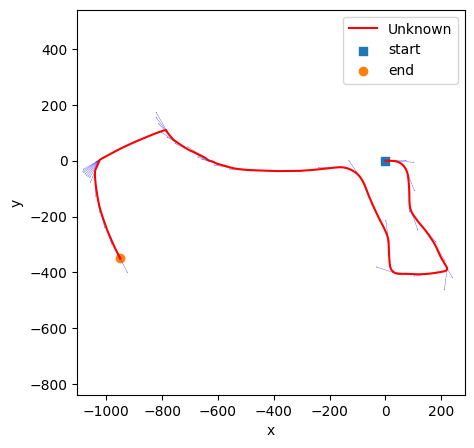

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [112]:
visualize_trajectory_2d(w_T_i, show_ori=True)

# Landmark Mapping via EKF Update

In [113]:
def get_calibration(K, b):
    '''
        Get calibration matrix M from K and b
        
        Input:
            K - camera calibration matrix
            b - stereo baseline
        Output:
            M - stereo camera calibration matrix
    '''
    M   = np.vstack([K[:2], K[:2]])
    arr = np.array([0, 0, -K[0,0]*float(b), 0]).reshape((4,1))
    M   = np.hstack([M, arr])
    return M

def projection(q):
    '''
        Get the projection of a vector in R^4
        
        Input:
            q  - a vector in R^4
        Output:
            pi - corresponding projection
    '''
    pi = q / q[2]
    return pi

def d_projection(q):
    '''
        Take a R^4 vector and return the derivative of its projection function
        
        Input:
            q  - a vector in R^4
        Output:
            dq - corresponding derivative of the projection function, size 4x4
    '''
    dq = np.zeros((4,4))
    dq[0,0] = 1
    dq[1,1] = 1
    dq[0,2] = -q[0]/q[2]
    dq[1,2] = -q[1]/q[2]
    dq[3,2] = -q[3]/q[2]
    dq[3,3] = 1
    dq = dq / q[2]
    return dq

def pixel_to_world(p, i_T_w, o_T_i, K, b):
    '''
        Get homogeneous coordinates xyz in world frame from left right pixels
        
        Input:
            p     - left right pixels, size 1x4
            i_T_w - current pose of IMU, size 4x4
            o_T_i - imu to optical frame rotation, size 3x3
            K     - camera calibration matrix
            b     - stereo baseline
        Output:
            m_w   - homogeneous coordinates
    '''
    uL, vL, uR, vR = p
    fsu = K[0,0]
    fsv = K[1,1]
    cu  = K[0,2]
    cv  = K[1,2]
    z   = (fsu*b) / (uL-uR)
    x   = z * (uL-cu) / fsu
    y   = z * (vL-cv) / fsv
    m_o = np.array([x,y,z,1]).reshape([4,1])
    m_i = np.dot(inv(o_T_i), m_o)
    m_w = np.dot(inv(i_T_w), m_i)
    return m_w

def get_Ht(H_list, num_feature, isSLAM=False):
    '''
        Get the model Jacobian
    '''
    if isSLAM:
        Nt = len(H_list)
        Ht = np.zeros([4*Nt, 3*num_feature+6])
        for i in range(Nt):
            j = H_list[i][0]      # landmark index
            H_obs  = H_list[i][1]
            H_pose = H_list[i][2]
            Ht[i*4:(i+1)*4, 3*j:3*(j+1)] = H_obs
            Ht[i*4:(i+1)*4, -6:] = H_pose
    else:
        Nt = len(H_list)
        Ht = np.zeros([4*Nt, 3*num_feature])
        for i in range(Nt):
            j = H_list[i][0]      # landmark index
            H = H_list[i][1]      # current Hij
            Ht[i*4:(i+1)*4,3*(j):3*(j+1)] = H
    return Ht

def get_Kt(cov, Ht, v):
    '''
        Get the Kalman gain
    '''
    V_noise  = np.eye(Ht.shape[0]) * v
    inv_term = np.dot(Ht, np.dot(cov, Ht.T)) + V_noise
    Kt       = np.dot(np.dot(cov, Ht.T), inv(inv_term))
    return Kt

In [100]:
def landmark_mapping(sampled_features, i_T_w, K, b, cam_T_imu, v_scale=100):
    '''
        Get landmarks position using EKF update
        
        Input:
            features  - landmarks
            i_T_w     - inverse imu pose
            K         - camera calibration matrix
            b         - stereo baseline
            cam_T_imu - imu to camera transformation
            v_scale   - scale of the observation noise
        Outputs:
            landmarks - landmarks position in the world frame
    '''
    num_feature = sampled_features.shape[1]
    mu_hasinit  = np.zeros(num_feature)
    mu      = np.zeros((4*num_feature, 1))
    cov     = np.eye(3*num_feature)
    M       = get_calibration(K,b)
    P       = np.vstack([np.eye(3), np.zeros([1,3])]) # projection matrix
    P_block = np.tile(P, [num_feature, num_feature])

    for i in tqdm(range(sampled_features.shape[2])):
        # if(i%100==0):
        Ut        = i_T_w[:,:,i]      # current inverse IMU pose
        sampled_feature   = sampled_features[:,:,i]   # current landmarks
        zt        = np.array([])      # to store zt
        zt_hat    = np.array([])      # to store zt_hat
        H_list = []                   # to store Hij
        observation_noise = np.random.randn() * np.sqrt(v_scale)
        for j in range(sampled_feature.shape[1]):
            # if is a valid feature
            if(sampled_feature[:,j] != np.array([-1,-1,-1,-1])).all():
                # check if has seen before
                # initialize if not seen before
                # update otherwise
                if(mu_hasinit[j] == 0):
                    m = pixel_to_world(sampled_feature[:,j], Ut, cam_T_imu, K, b)
                    mu[4*j:4*(j+1)] = m
                    cov[3*j:3*(j+1), 3*j:3*(j+1)] = np.eye(3) * 1e-3
                    mu_hasinit[j] = 1     # mark as seen
                else:
                    mu_curr = mu[4*j:4*(j+1)]
                    q       = np.dot(cam_T_imu, np.dot(Ut, mu_curr))
                    zt      = np.concatenate((zt, sampled_feature[:,j]+observation_noise), axis=None)
                    zt_hat  = np.concatenate((zt_hat, np.dot(M, projection(q))), axis=None)
                    # compute H_ij
                    H       = ((M.dot(d_projection(q))).dot(cam_T_imu).dot(Ut)).dot(P)
                    H_list.append((j, H))

        Nt     = len(H_list)
        zt     = zt.reshape([4*Nt,1])
        zt_hat = zt_hat.reshape([4*Nt,1])
        Ht     = get_Ht(H_list, num_feature)
        Kt     = get_Kt(cov, Ht, v_scale)

        # update mu and cov
        mu = mu + P_block.dot(Kt.dot(zt-zt_hat))
        cov = np.dot((np.eye(3*num_feature) - np.dot(Kt,Ht)),cov)

    landmarks = mu.reshape([num_feature,4])
    return landmarks

In [114]:
cam_T_imu = inv(imu_T_cam)
roll_rotation = np.array([[1, 0, 0], [0, -1, 0], [0 , 0, -1]])
cam_T_imu[:3, :3] = np.matmul(roll_rotation, cam_T_imu[:3, :3])

v_scale = 100
num_feature = sampled_features.shape[1]
mu_hasinit  = np.zeros(num_feature)
mu      = np.zeros((4*num_feature, 1))
cov     = np.eye(3*num_feature)
M       = get_calibration(K,b)
P       = np.vstack([np.eye(3), np.zeros([1,3])]) # projection matrix
P_block = np.tile(P, [num_feature, num_feature])

for i in tqdm(range(sampled_features.shape[2])):
    Ut        = i_T_w[:,:,i]      # current inverse IMU pose
    sampled_feature   = sampled_features[:,:,i]   # current landmarks
    zt        = np.array([])      # to store zt
    zt_hat    = np.array([])      # to store zt_hat
    H_list = []                   # to store Hij
    observation_noise = np.random.randn() * np.sqrt(v_scale)
    for j in range(sampled_feature.shape[1]):
        # if is a valid feature
        if(sampled_feature[:,j] != np.array([-1,-1,-1,-1])).all():
            # check if has seen before
            # initialize if not seen before
            # update otherwise
            if(mu_hasinit[j] == 0):
                m = pixel_to_world(sampled_feature[:,j], Ut, cam_T_imu, K, b)
                mu[4*j:4*(j+1)] = m
                cov[3*j:3*(j+1), 3*j:3*(j+1)] = np.eye(3) * 1e-3
                mu_hasinit[j] = 1     # mark as seen
            else:
                mu_curr = mu[4*j:4*(j+1)]
                q       = np.dot(cam_T_imu, np.dot(Ut, mu_curr))
                zt      = np.concatenate((zt, sampled_feature[:,j]+observation_noise), axis=None)
                zt_hat  = np.concatenate((zt_hat, np.dot(M, projection(q))), axis=None)
                # compute H_ij
                H       = ((M.dot(d_projection(q))).dot(cam_T_imu).dot(Ut)).dot(P)
                H_list.append((j, H))

    Nt     = len(H_list)
    zt     = zt.reshape([4*Nt,1])
    zt_hat = zt_hat.reshape([4*Nt,1])
    Ht     = get_Ht(H_list, num_feature)
    Kt     = get_Kt(cov, Ht, v_scale)

    # update mu and cov
    mu = mu + P_block.dot(Kt.dot(zt-zt_hat))
    cov = np.dot((np.eye(3*num_feature) - np.dot(Kt,Ht)),cov)

landmarks = mu.reshape([num_feature,4])

100%|██████████| 3026/3026 [20:10<00:00,  2.50it/s]    


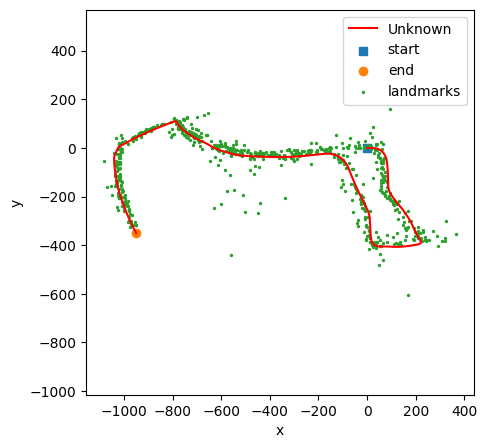

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [115]:
visualize(w_T_i, landmarks)

# Visual-Inertial SLAM

In [117]:
def circle(m):
    '''
        circle operator
        
        Input:
            m - a vector in R^4, [x,y,z,1]
        Output:
            result - a matrix of size 4x6
    '''
    s      = m[:3]
    s_hat  = hat_map(s)
    result = np.hstack((np.eye(3), -s_hat))
    result = np.vstack((result, np.zeros((1,6))))
    return result

In [118]:
def visual_slam(t, v, w, sampled_features, K, b, cam_T_imu, v_scale=100, w_scale=10e-5):
    # get time discretization
    tau = t[:,1:] - t[:,:-1]
    n = tau.shape[1]
    
    num_feature = sampled_features.shape[1]

    # initialize mu and covariance
    mu_imu  = np.eye(4)
    mu_obs  = np.zeros((4*num_feature, 1))
    cov     = np.eye(3*num_feature+6)
    W_noise = np.eye(6) * w_scale

    # poses
    imu_pose            = np.zeros((4,4,n+1)) # w_T_i
    inv_imu_pose        = np.zeros((4,4,n+1)) # i_T_w
    imu_pose[:,:,0]     = mu_imu
    inv_imu_pose[:,:,0] = inv(mu_imu)

    mu_hasinit  = np.zeros(num_feature)
    M       = get_calibration(K,b)
    P       = np.vstack([np.eye(3), np.zeros([1,3])]) # projection matrix
    P_block = np.tile(P, [num_feature, num_feature])

    for i in tqdm(range(n)):
        # if(i%100==0):
        #     print(i)
        dt        = tau[:,i]          # time interval
        Ut        = mu_imu            # current inverse IMU pose
        sampled_feature   = sampled_features[:,:,i]   # current landmarks
        zt        = np.array([])      # to store zt
        zt_hat    = np.array([])      # to store zt_hat
        H_list = []                   # to store Hij
        observation_noise = np.random.randn() * np.sqrt(v_scale)
        for j in range(sampled_feature.shape[1]):
            # if is a valid feature
            if(sampled_feature[:,j] != np.array([-1,-1,-1,-1])).all():
                # check if has seen before
                # initialize if not seen before
                # update otherwise
                if(mu_hasinit[j] == 0):
                    m = pixel_to_world(sampled_feature[:,j], Ut, cam_T_imu, K, b)
                    mu_obs[4*j:4*(j+1)] = m
                    cov[3*j:3*(j+1), 3*j:3*(j+1)] = np.eye(3) * 1e-4
                    mu_hasinit[j] = 1     # mark as seen
                else:
                    mu_curr = mu_obs[4*j:4*(j+1)]
                    q1      = np.dot(cam_T_imu, np.dot(Ut, mu_curr))
                    q2      = circle(np.dot(Ut, mu_curr))
                    zt      = np.concatenate((zt, sampled_feature[:,j]+observation_noise), axis=None)
                    zt_hat  = np.concatenate((zt_hat, np.dot(M, projection(q1))), axis=None)
                    # compute H
                    H_obs   = ((M.dot(d_projection(q1))).dot(cam_T_imu).dot(Ut)).dot(P)
                    H_pose  = (M.dot(d_projection(q1))).dot(cam_T_imu).dot(q2)
                    H_list.append((j, H_obs, H_pose))

        Nt     = len(H_list)
        zt     = zt.reshape([4*Nt,1])
        zt_hat = zt_hat.reshape([4*Nt,1])
        Ht     = get_Ht(H_list, num_feature, isSLAM=True)
        Kt     = get_Kt(cov, Ht, v_scale)

        # update mean and cov
        Kt_obs  = Kt[:-6,:]  # 3M x 4Nt
        Kt_pose = Kt[-6:, :] #  6 x 4Nt

        p      = np.dot(Kt_pose, zt-zt_hat)[:3].flatten()
        theta  = np.dot(Kt_pose, zt-zt_hat)[-3:].flatten()

        mu_obs = mu_obs + P_block.dot(Kt_obs.dot(zt-zt_hat))
        
        mu_imu = np.dot(approx_rodrigues_3(p, theta), mu_imu)
        cov    = np.dot((np.eye(3*num_feature+6) - np.dot(Kt,Ht)),cov)
        
        # store imu pose
        inv_imu_pose[:,:,i+1] = mu_imu
        imu_pose[:,:,i+1] = inv(mu_imu)

        # predict mean and cov
        noise  = np.random.randn() * w_scale
        v_curr = v[:,i] + noise
        w_curr = w[:,i] + noise
        mu_imu = mu_predict(mu_imu, v_curr, w_curr, dt)
        cov[-6:,-6:]  = cov_predict(cov[-6:,-6:], v_curr, w_curr, dt, W_noise)
        
    mu_obs = mu_obs.reshape((num_feature, 4))
    return inv_imu_pose, imu_pose, mu_obs

In [119]:
# slam_iTw, slam_wTi, slam_landmarks = visual_slam(t, linear_velocity, angular_velocity, sampled_features, K, b, cam_T_imu)
v = linear_velocity
w = angular_velocity
v_scale = 100
w_scale = 10e-5
# get time discretization
tau = t[:,1:] - t[:,:-1]
n = tau.shape[1]

num_feature = sampled_features.shape[1]

# initialize mu and covariance
mu_imu  = np.eye(4)
mu_obs  = np.zeros((4*num_feature, 1))
cov     = np.eye(3*num_feature+6)
W_noise = np.eye(6) * w_scale

# poses
imu_pose            = np.zeros((4,4,n+1)) # w_T_i
inv_imu_pose        = np.zeros((4,4,n+1)) # i_T_w
imu_pose[:,:,0]     = mu_imu
inv_imu_pose[:,:,0] = inv(mu_imu)

mu_hasinit  = np.zeros(num_feature)
M       = get_calibration(K,b)
P       = np.vstack([np.eye(3), np.zeros([1,3])]) # projection matrix
P_block = np.tile(P, [num_feature, num_feature])

for i in tqdm(range(n)):
    dt        = tau[:,i]          # time interval
    Ut        = mu_imu            # current inverse IMU pose
    sampled_feature   = sampled_features[:,:,i]   # current landmarks
    zt        = np.array([])      # to store zt
    zt_hat    = np.array([])      # to store zt_hat
    H_list = []                   # to store Hij
    observation_noise = np.random.randn() * np.sqrt(v_scale)
    for j in range(sampled_feature.shape[1]):
        # if is a valid feature
        if(sampled_feature[:,j] != np.array([-1,-1,-1,-1])).all():
            # check if has seen before
            # initialize if not seen before
            # update otherwise
            if(mu_hasinit[j] == 0):
                m = pixel_to_world(sampled_feature[:,j], Ut, cam_T_imu, K, b)
                mu_obs[4*j:4*(j+1)] = m
                cov[3*j:3*(j+1), 3*j:3*(j+1)] = np.eye(3) * 1e-4
                mu_hasinit[j] = 1     # mark as seen
            else:
                mu_curr = mu_obs[4*j:4*(j+1)]
                q1      = np.dot(cam_T_imu, np.dot(Ut, mu_curr))
                q2      = circle(np.dot(Ut, mu_curr))
                zt      = np.concatenate((zt, sampled_feature[:,j]+observation_noise), axis=None)
                zt_hat  = np.concatenate((zt_hat, np.dot(M, projection(q1))), axis=None)
                # compute H
                H_obs   = ((M.dot(d_projection(q1))).dot(cam_T_imu).dot(Ut)).dot(P)
                H_pose  = (M.dot(d_projection(q1))).dot(cam_T_imu).dot(q2)
                H_list.append((j, H_obs, H_pose))

    Nt     = len(H_list)
    zt     = zt.reshape([4*Nt,1])
    zt_hat = zt_hat.reshape([4*Nt,1])
    Ht     = get_Ht(H_list, num_feature, isSLAM=True)
    Kt     = get_Kt(cov, Ht, v_scale)

    # update mean and cov
    Kt_obs  = Kt[:-6,:]  # 3M x 4Nt
    Kt_pose = Kt[-6:, :] #  6 x 4Nt

    p      = np.dot(Kt_pose, zt-zt_hat)[:3].flatten()
    theta  = np.dot(Kt_pose, zt-zt_hat)[-3:].flatten()

    mu_obs = mu_obs + P_block.dot(Kt_obs.dot(zt-zt_hat))
    
    mu_imu = np.dot(approx_rodrigues_3(p, theta), mu_imu)
    cov    = np.dot((np.eye(3*num_feature+6) - np.dot(Kt,Ht)),cov)
    
    # store imu pose
    inv_imu_pose[:,:,i+1] = mu_imu
    imu_pose[:,:,i+1] = inv(mu_imu)

    # predict mean and cov
    noise  = np.random.randn() * w_scale
    v_curr = v[:,i] + noise
    w_curr = w[:,i] + noise
    mu_imu = mu_predict(mu_imu, v_curr, w_curr, dt)
    
    cov[-6:,-6:]  = cov_predict(cov[-6:,-6:], v_curr, w_curr, dt, W_noise)
    
mu_obs = mu_obs.reshape((num_feature, 4))

slam_iTw, slam_wTi, slam_landmarks = inv_imu_pose, imu_pose, mu_obs

100%|██████████| 3025/3025 [11:29<00:00,  4.39it/s]


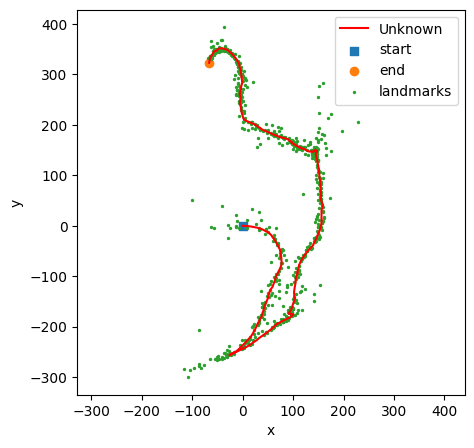

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [120]:
visualize(slam_wTi, slam_landmarks)

10.png


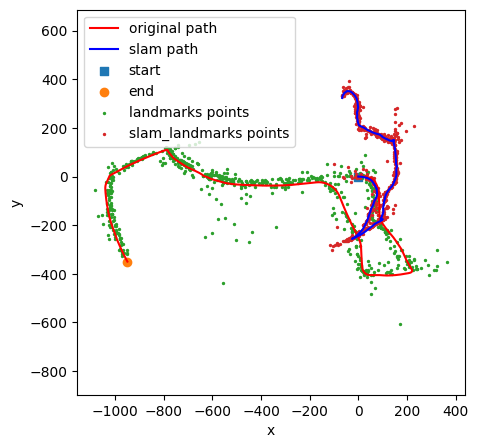

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [122]:
def compare_result(pose,slam_pose,landmarks,slam_landmarks,path_name="Unknown",show_ori=False):
    '''
    function to compare 2 trajectories and landmarks in 2D
    Input:
        pose:   4*4*N matrix representing the camera pose, 
                where N is the number of pose, and each
                4*4 matrix is in SE(3)
    '''
    fig,ax = plt.subplots(figsize=(5,5))
    n_pose = pose.shape[2]
    ax.plot(pose[0,3,:],pose[1,3,:],'r-',label='original path')
    ax.plot(slam_pose[0,3,:],slam_pose[1,3,:],'b-',label='slam path')
    ax.scatter(pose[0,3,0],pose[1,3,0],marker='s',label="start")
    ax.scatter(pose[0,3,-1],pose[1,3,-1],marker='o',label="end")
    ax.scatter(landmarks[:,0],landmarks[:,1],s=2, marker='o',label="landmarks points")
    ax.scatter(slam_landmarks[:,0],slam_landmarks[:,1],s=2, marker='o',label="slam_landmarks points")
    if show_ori:
        select_ori_index = list(range(0,n_pose,int(n_pose/50)))
        yaw_list = []
        for i in select_ori_index:
            _,_,yaw = mat2euler(pose[:3,:3,i])
            yaw_list.append(yaw)
        dx = np.cos(yaw_list)
        dy = np.sin(yaw_list)
        dx,dy = [dx,dy]/np.sqrt(dx**2+dy**2)
        ax.quiver(pose[0,3,select_ori_index],pose[1,3,select_ori_index],dx,dy,\
            color="b",units="xy",width=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.grid(False)
    ax.legend()
    print(path_name)
    plt.savefig(path_name, dpi=150)
    plt.show(block=True)
    return fig, ax

pathName = filename.split("/")[-1].split(".")[0] + ".png"
compare_result(w_T_i, slam_wTi, landmarks, slam_landmarks, path_name = pathName)